In [1]:
import os
import dask.dataframe as dd
from dask.distributed import Client
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

import sys
sys.path.insert(0, '/home/djl34/lab_pd/kl/git/KL/scripts')
import post_analysis

pd_data_dir = "/home/djl34/lab_pd/data"
aso_data_dir = "/home/djl34/lab_pd/aso/data"
KL_data_dir = "/home/djl34/lab_pd/kl/data"
scratch_dir = "/n/scratch3/users/d/djl34"

In [2]:
## get neutral SFS
## get selected SFS
## plot both
## show difference as betas

neutral_sfs = os.path.join(KL_data_dir, "whole_genome/allele_freq/adaptive_bins/all.tsv")
nonsense = os.path.join(scratch_dir, "kl_input/" +  "single_feature/nonsense/nonsense_shet_0.1_cutoff_chr_0.tsv")

neutral = pd.read_csv(neutral_sfs, sep = "\t")
neutral = neutral.drop(["mu", "sum"], axis = 1)

nonsense = pd.read_csv(nonsense, sep = "\t")


In [3]:
# mu_index = 10
# nonsense_mu = nonsense.copy()
nonsense_mu_value_counts = pd.DataFrame(nonsense["mu_index"].value_counts())
# nonsense_mu = nonsense[nonsense["mu_index"] == mu_index]

nonsense_valuecounts = pd.DataFrame(nonsense.value_counts("Freq_bin")).reset_index()

# neutral_prob = pd.DataFrame(neutral.iloc[mu_index])

nonsense_mu_value_counts = nonsense_mu_value_counts.join(neutral, how = "left")

nonsense_mu_prob = nonsense_mu_value_counts.mul(nonsense_mu_value_counts['mu_index'], axis=0)

nonsense_mu_prob = nonsense_mu_prob.drop("mu_index", axis = 1)

neutral_prob = pd.DataFrame(nonsense_mu_prob.sum(axis = 0) / nonsense_mu_value_counts["mu_index"].sum()).reset_index()

nonsense_valuecounts["prob"] = nonsense_valuecounts[0]/nonsense_valuecounts[0].sum()

neutral_prob = neutral_prob.rename({'index': 'Freq_bin', 0: 'Neutral sites'}, axis = 1)

nonsense_valuecounts = nonsense_valuecounts.rename({"prob": "Nonsense sites"}, axis = 1)

In [4]:
neutral_prob["Freq_bin"] = neutral_prob["Freq_bin"].astype(float).astype(int)
nonsense_valuecounts["Freq_bin"] = nonsense_valuecounts["Freq_bin"].astype(int)

In [5]:
sfs = neutral_prob.merge(nonsense_valuecounts[["Freq_bin", "Nonsense sites"]], on = "Freq_bin", how = "left")

In [6]:
sfs = sfs.fillna(0)

In [7]:
sfs

,Freq_bin,Neutral sites,Nonsense sites
0,0,0.933107,0.993537
1,1,0.033375,0.005749
2,2,0.009365,0.000443
3,3,0.004658,0.000133
4,4,0.004817,0.000064
5,5,0.005462,0.000030
6,6,0.004715,0.000030
7,7,0.002232,0.000011
8,8,0.001223,0.000005
9,9,0.001046,0.000000


In [8]:
sfs_melt = pd.melt(sfs, id_vars=['Freq_bin'], value_vars=['Neutral sites', 'Nonsense sites'], var_name = "Site Type", value_name = "Proportion")

In [9]:
sfs_melt.head()

,Freq_bin,Site Type,Proportion
0,0,Neutral sites,0.933107
1,1,Neutral sites,0.033375
2,2,Neutral sites,0.009365
3,3,Neutral sites,0.004658
4,4,Neutral sites,0.004817


In [12]:
sns.despine(bottom = True, left = True)

<Figure size 640x480 with 0 Axes>

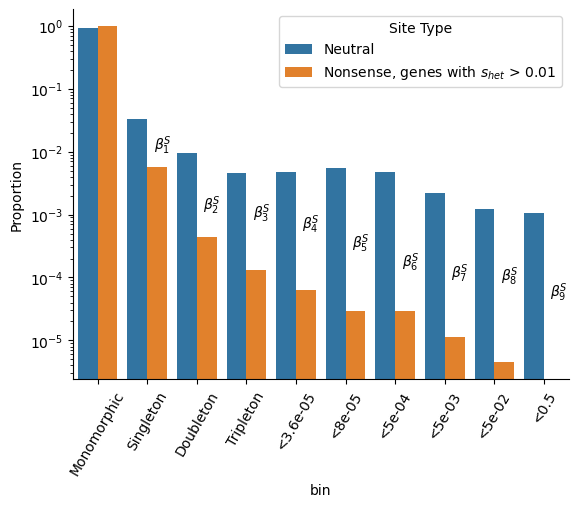

In [17]:
sfs_plot = sfs_melt
# sfs_plot = sfs_melt[sfs_melt["Freq_bin"] != 0]

sfs_plot["bin"] = sfs_plot.apply(lambda row: post_analysis.freq_bin_to_AF_range(row["Freq_bin"], short = True), axis=1)
sfs_plot["Site Type"] = sfs_plot["Site Type"].replace("Nonsense sites", "Nonsense, genes with $s_{het}$ > 0.01")
sfs_plot["Site Type"] = sfs_plot["Site Type"].replace("Neutral sites", "Neutral")

sns.barplot(sfs_plot, x="bin", y="Proportion", hue="Site Type")
plt.xticks(rotation=60)
plt.yscale("log")
sns.despine(bottom = False, left = False)


y_list = [0.011, 0.0012, 0.0009, 0.0006, 0.0003, 0.00015, 0.0001, 0.00009, 0.00005]

for i in range(9):
    x = 1.13 + i
    y = y_list[i]

    arrow = u'$\u2193$'
    
    text = str(i + 1)
    plt.text(x, y, r"$\beta^S_" + text +"$")
    
plt.savefig('multinomial_neutral_beta.pdf',dpi=300, bbox_inches = "tight", transparent=True)  
